In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split
import gc; gc.enable() # memory is tight

from keras import layers, models
from keras import backend as K
from keras.optimizers import Adam

In [2]:
path='/content/drive/MyDrive/Colab Notebooks/train/'

images = []
masks = []
#print(os.listdir(path))

for f in listdir(path):
  if f.endswith(".csv"):
    masks.append(path+f)
  else:
    images.append(path+f)

df = pd.DataFrame(np.column_stack([images, masks]), columns=['images', 'masks'])

In [3]:
df.head()

,images,masks
0,/content/drive/MyDrive/Colab Notebooks/train/a...,/content/drive/MyDrive/Colab Notebooks/train/a...
1,/content/drive/MyDrive/Colab Notebooks/train/a...,/content/drive/MyDrive/Colab Notebooks/train/a...
2,/content/drive/MyDrive/Colab Notebooks/train/a...,/content/drive/MyDrive/Colab Notebooks/train/a...
3,/content/drive/MyDrive/Colab Notebooks/train/a...,/content/drive/MyDrive/Colab Notebooks/train/a...
4,/content/drive/MyDrive/Colab Notebooks/train/a...,/content/drive/MyDrive/Colab Notebooks/train/a...


In [4]:
df1 = df.sort_values(by='images')['images'].reset_index()
# df1 = df.sort_values(by='a')['a']
df2 = df.sort_values(by='masks')['masks'].reset_index()
# df2 = df.sort_values(by='b')['b']
df['images'] = df1['images']
df['masks'] = df2['masks']
del df1, df2

In [5]:
df.head()

,images,masks
0,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
1,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
2,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
3,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
4,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...


In [6]:
type(df)

pandas.core.frame.DataFrame

In [7]:
f=open(path+"0041e69431bf872309d1aff628b6494f.csv").readlines()
z= [x.split(",") for x in f]
type(z)


list

In [8]:
# csv path, img shape
# düzeltme yapılacak. bir fotoda birden çok eleman olması durumu için
def create_mask(mask_dir, img_shape):
    mask = np.zeros(shape=(img_shape[0], img_shape[1], 1))

    with open(mask_dir) as f:
        content = f.readlines()
    content = [x.split(",") for x in content]
    ul_col, ul_row = int(float(content[1][4])), int(float(content[1][5]))
    lr_col, lr_row = int(float(content[1][6])), int(float(content[1][7]))
    

    mask[ul_row:lr_row, ul_col:lr_col, 0] = 1 
    return mask

In [9]:
df_train, df_val = train_test_split(df, test_size=0.25, shuffle=False)
print(df_train)
print(type(df_train.images))
#print(df_val)
BATCH_SIZE = 64
EDGE_CROP = 16
NB_EPOCHS = 30
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

                                                 images                                              masks
0     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
1     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
2     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
3     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
4     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
...                                                 ...                                                ...
1546  /content/drive/MyDrive/Colab Notebooks/train/8...  /content/drive/MyDrive/Colab Notebooks/train/8...
1547  /content/drive/MyDrive/Colab Notebooks/train/8...  /content/drive/MyDrive/Colab Notebooks/train/8...
1548  /content/drive/MyDrive/Colab No

In [10]:
def create_images_generator(df_in, batch_size, resized_shape):
    batch_image = []
    batch_mask = []
    df_in_list = df_in.values.tolist()
    #print(len(df_in_list))
    #np.random.shuffle(df_in_list)
    # return df_in_list    
    
    while True:
#         np.random.shuffle(df_in_list)
        for image_path, mask_path in df_in_list:
            image_r = cv2.imread(image_path)
            mask_r = create_mask(mask_path, image_r.shape)
            
            image_r = cv2.resize(image_r,(resized_shape[1], resized_shape[0]))
            mask_r = cv2.resize(mask_r,(resized_shape[1], resized_shape[0]))
            
            
            
            batch_image.append(image_r)
            batch_mask.append(mask_r)
#Sıkıntı burda
            if len(batch_mask)>=batch_size:
                yield np.float32(np.stack((batch_image), 0)/255.0), np.stack(np.float32(np.expand_dims(batch_mask, -1)), 0)
                batch_image, batch_mask = [], []

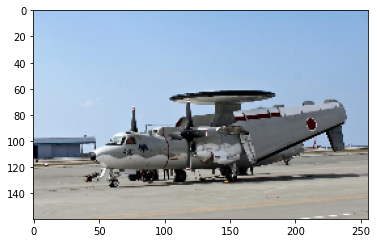

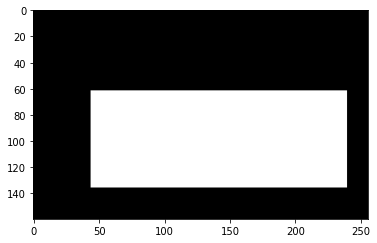

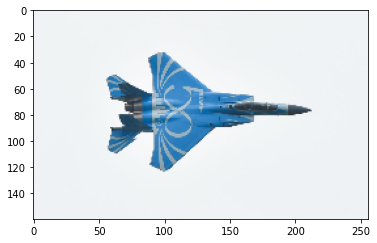

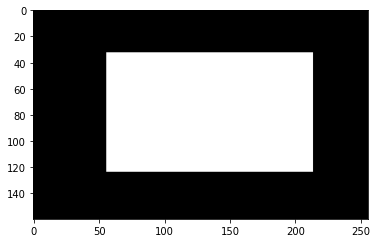

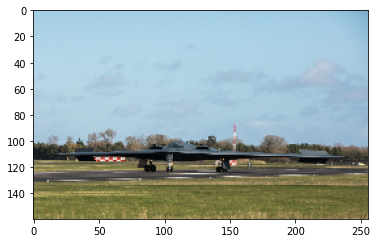

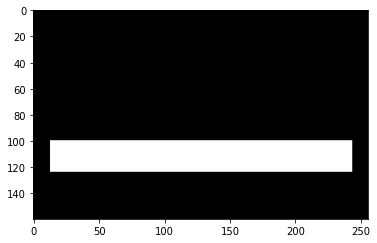

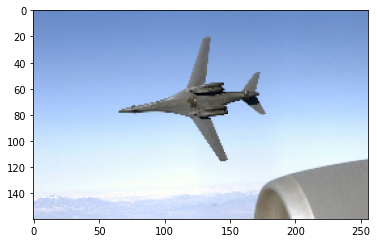

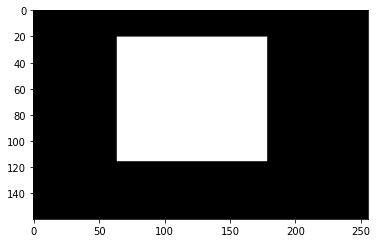

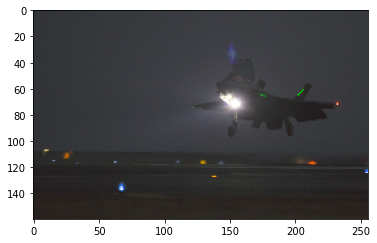

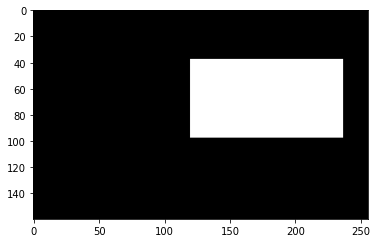

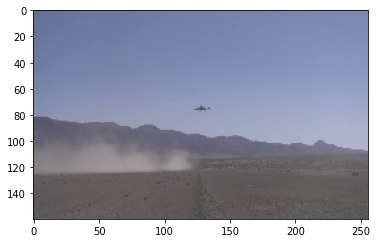

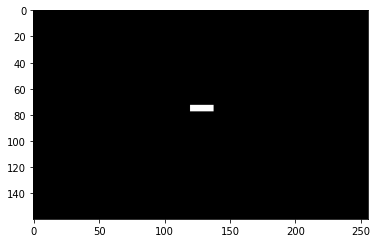

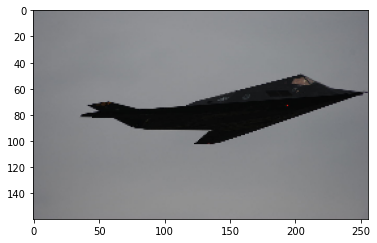

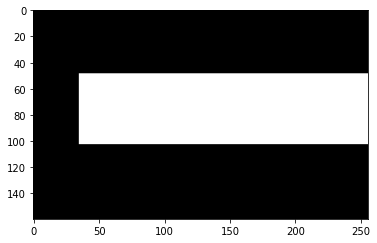

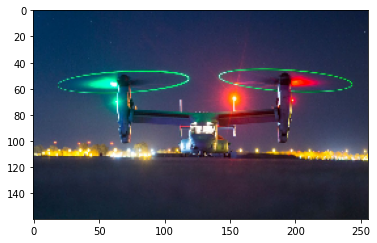

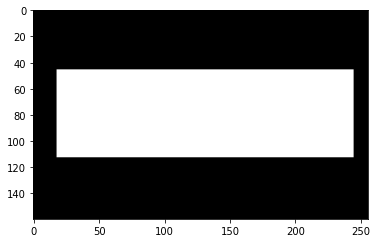

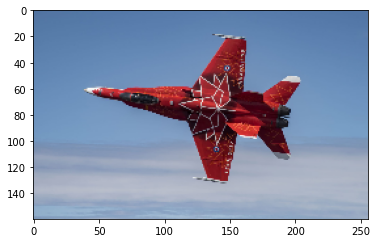

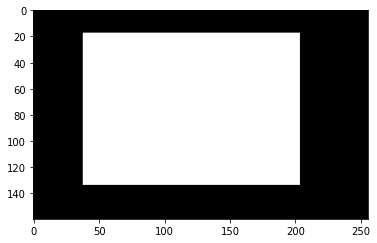

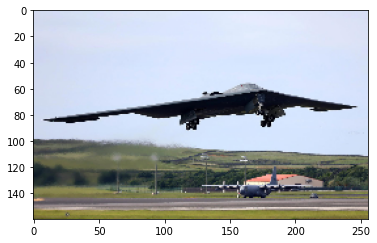

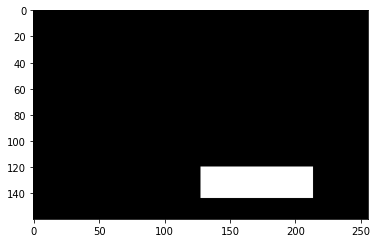

In [11]:
resized_shape = (160, 256)                
train_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)
batch_img, batch_mask = next(train_gen)
for i in range(10):

    im = np.array(255*batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.imshow(im_mask[:,:,0], cmap= 'gray')
    plt.show()

In [12]:
from keras.preprocessing.image import ImageDataGenerator
args_dg = dict(featurewise_center = False, 
               samplewise_center = False, 
               rotation_range = 2, 
               width_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.9, 1.1], 
               horizontal_flip = False, 
               vertical_flip = False,
               fill_mode = 'constant',
               data_format = 'channels_last')

if AUGMENT_BRIGHTNESS:
    args_dg['brightness_range'] = [0.5, 1.5]

image_gen = ImageDataGenerator(**args_dg)

if AUGMENT_BRIGHTNESS:
    args_dg.pop('brightness_range')
mask_gen = ImageDataGenerator(**args_dg)

In [13]:
def make_augment_generator(img_mask_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img_in, mask_in in img_mask_gen:
        seed = np.random.choice(range(9999))
        aug_img_in = image_gen.flow(255*img_in, 
                                 batch_size=img_in.shape[0],
                                 seed = seed, 
                                 shuffle=True)
        aug_mask_in = mask_gen.flow(mask_in, 
                                    batch_size=img_in.shape[0],
                                    seed=seed,
                                    shuffle=True)
        yield next(aug_img_in)/255.0, next(aug_mask_in)

In [14]:
def calc_IOU(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f*y_pred_f)
    
    return (2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
def calc_IOU_loss(y_true, y_pred):
    return -calc_IOU(y_true, y_pred)

# In[]
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
def create_unet():
    
    # input_img = layers.Input(batch_img.shape[1:], name = 'RGB_Input')
    input_img = layers.Input((resized_shape[0],resized_shape[1],3), name = 'RGB_Input')
    pp_in_layer = input_img
             
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(pp_in_layer)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)
    
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    
    u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)
    
    d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    # d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
    # d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
    if NET_SCALING is not None:
        d = layers.UpSampling2D(NET_SCALING)(d)
    
    seg_model = models.Model(inputs=[input_img], outputs=[d])
    seg_model.summary()
    
    return seg_model

In [16]:
model = create_unet()
model.compile(optimizer=Adam(lr=1e-4),
              loss=calc_IOU_loss, metrics=["accuracy"])
# In[]
# history = model.fit_generator(train_gen,
#             samples_per_epoch=40,
#                               nb_epoch=2)    

train_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)
valid_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)

# aug_gen = make_augment_generator(train_gen)

val_img, val_mask = next(valid_gen) 


loss_history = [model.fit_generator(train_gen,
 steps_per_epoch=20,
 epochs=50,
 validation_data=(val_img, val_mask),workers=1)]

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 160, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 160, 256, 8)  224         RGB_Input[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 160, 256, 8)  584         conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 80, 128, 8)   0           conv2d_20[0][0]                  
_______________________________________________________________________________________

In [17]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


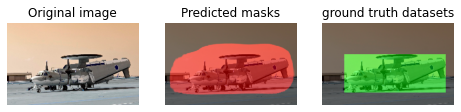

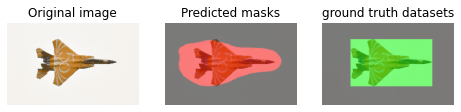

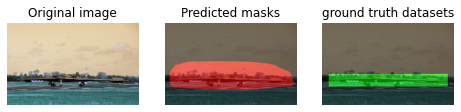

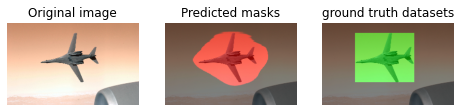

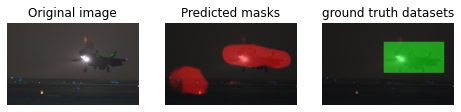

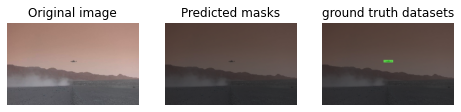

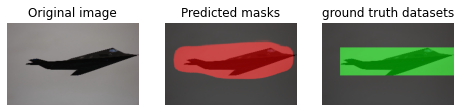

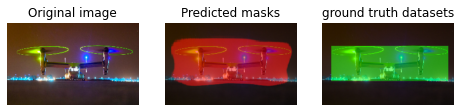

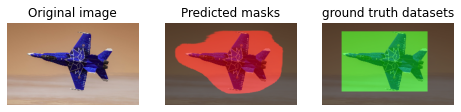

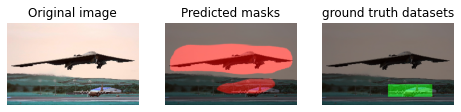

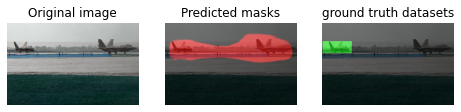

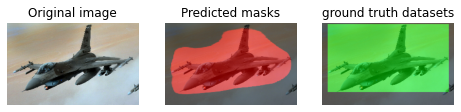

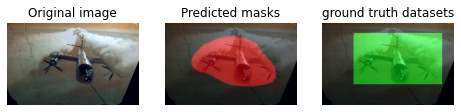

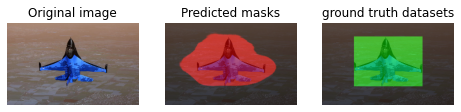

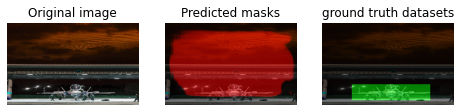

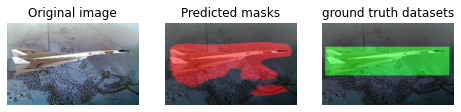

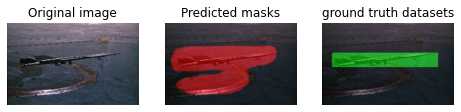

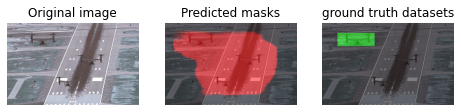

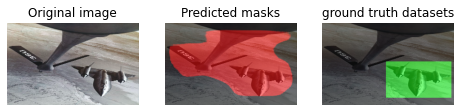

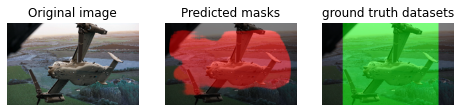

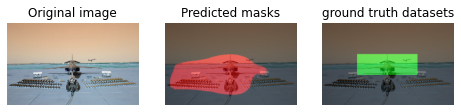

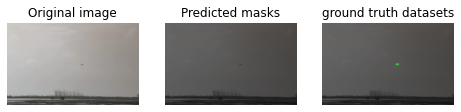

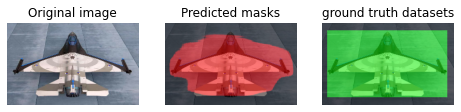

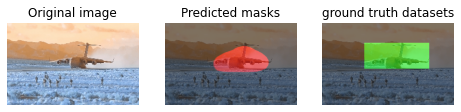

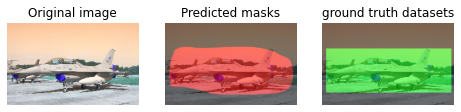

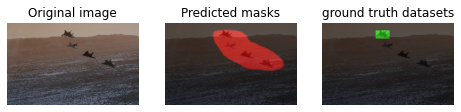

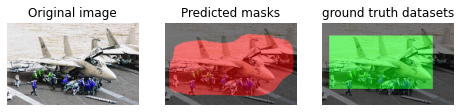

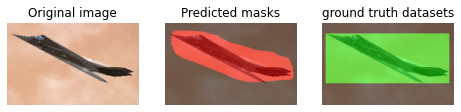

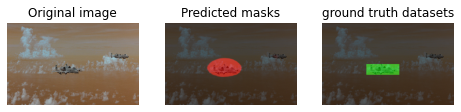

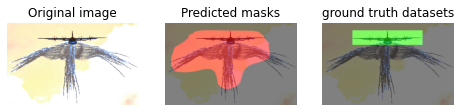

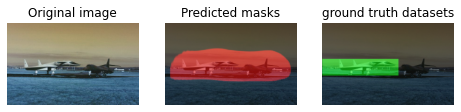

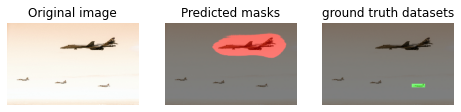

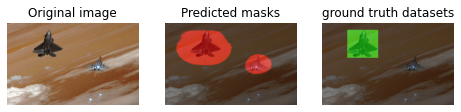

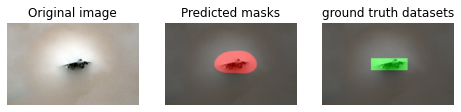

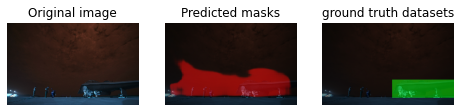

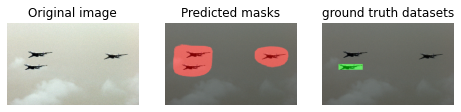

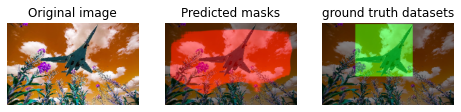

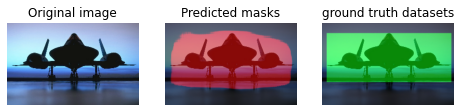

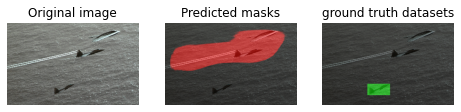

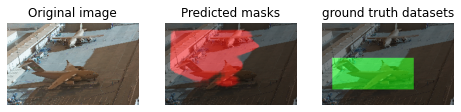

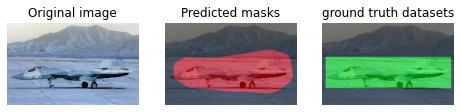

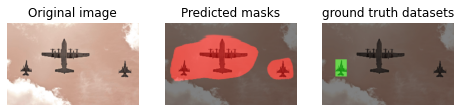

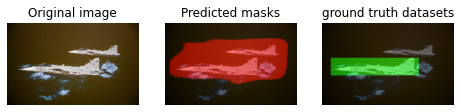

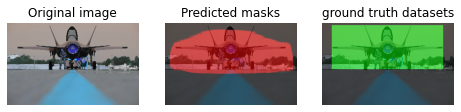

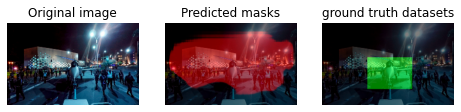

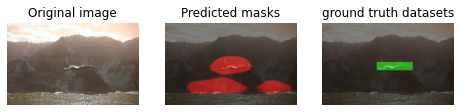

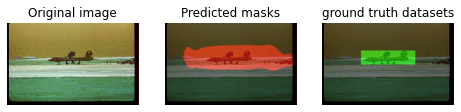

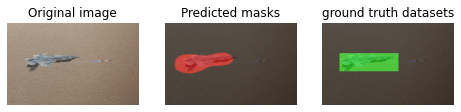

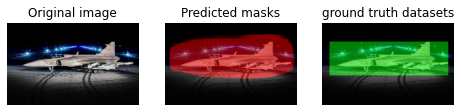

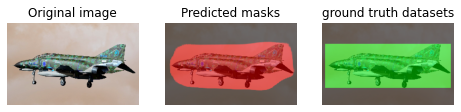

In [19]:
pred_all= model.predict(val_img)
np.shape(pred_all)

for i in range(50):

    im = np.array(255*val_img[i],dtype=np.uint8)
    im_mask = np.array(255*val_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    im_pred1 = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred1 = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    temp1 = rgb_mask_pred[:,:,1:3]
    temp2 = rgb_mask_pred[:,:,1:2]
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:3]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted masks')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('ground truth datasets')
    plt.axis('off')
    plt.show()    